# Import des Data

On importe toutes les bibliothèques.

In [4]:
import utilities
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import spacy
import re
import sklearn
import random
import textdistance

from spacy.vocab               import Vocab
from spacy.language            import Language
from spacy.tokens              import Token
from spacymoji                 import Emoji
from   sklearn.tree            import DecisionTreeClassifier
from   sklearn.model_selection import train_test_split
from sklearn                   import metrics






Importation du corpus.

In [2]:
corpus = pd.read_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel10k.csv", sep=";", parse_dates=["publication_time"])

# on récupére les posts en anglais
mask = corpus["language"] == 'en'
corpus = corpus.loc[mask]
chanel = corpus['text'].tolist()
publication_time_chanel = corpus['publication_time'].tolist()

print(f"# documents in corpus: {len(chanel)}")

# documents in corpus: 1802


On définit les différents éléments de la *pipeline* `spacy` pour détecter les emojis et les hashtags.

In [5]:
nlp = spacy.load("en_core_web_sm")

@Language.component("hashtag")
def hashtag_pipe(
    doc: spacy.tokens.Doc
) -> spacy.tokens.Doc:
    """
    A spaCy pipeline component that merges tokens of the form #word into a single token.

    Parameters
    ----------
    doc : spacy.tokens.Doc
        The input spaCy Doc object to process.

    Returns
    -------
    spacy.tokens.Doc
        The processed spaCy Doc object with hashtags merged into a single token.
    """
    len_doc = -1
    for token in doc:
        len_doc=len_doc+1
    merged_hashtag = False
    while True:
        for token in doc:
            if token.text == '#':
                if(token.head is not None and token.i!=len_doc):
                    start_index = token.i
                    end_index = start_index + 1
                    with doc.retokenize() as retokenizer:
                        retokenizer.merge(doc[start_index:end_index+1])
                        merged_hashtag = True
                        break
        if not merged_hashtag:
            break
        merged_hashtag = False
    return doc

nlp.add_pipe("emoji", first=True)
nlp.add_pipe("hashtag", first=True)
Token.set_extension("is_hashtag", getter=lambda token: token.text[0] in ("#"), force=True)

# Creation d'un sample de validation

In [9]:
chanel_junk_valid = corpus[['text','publication_time']].sample(n=700, random_state = 42)

In [10]:
dist = textdistance.levenshtein.normalized_distance
chanel_junk_valid_dd = utilities.delete_duplicates(chanel_junk_valid['text'].tolist(),chanel_junk_valid['publication_time'].tolist(),0.6,dist)

In [11]:
len(chanel_junk_valid_dd)

390

In [12]:
chanel_junk_valid_df= pd.DataFrame()
chanel_junk_valid_df['text'] = chanel_junk_valid_dd

In [13]:
chanel_junk_valid_df.to_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid.csv")
# Ajout de la variable is_junk sur excel

### Sample de validation : 

In [6]:
chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid_new.xlsx')
chanel_junk_valid_new = chanel_junk_valid_new[['text','is_junk']].dropna()

# Ajout de features

### Présence d'un URL

In [7]:
chanel_junk_valid_new['has_URL'] = utilities.get_presence_of_URL(corpus= chanel_junk_valid_new['text'], nlp= nlp  )

In [5]:
chanel_junk_valid_new.head()

,text,is_junk,has_URL
0,Went to see sweeneytoddbway with joshgroban. I...,0,0.0
1,Citty strolling 💫📷,1,0.0
2,Chanel blue sandals for the summer💙,0,0.0
3,S O P H I E L E G E N D R E\n\nPhotography s...,1,0.0
4,She judges it fr,0,0.0


### Présence de numéros de téléphone

In [8]:
chanel_junk_valid_new['has_phone_number'] = utilities.get_presence_of_phone_numbers(corpus= chanel_junk_valid_new['text'], nlp= nlp  )

In [10]:
chanel_junk_valid_new.head()

,text,is_junk,has_phone_number
0,Went to see sweeneytoddbway with joshgroban. I...,0,1.0
1,Citty strolling 💫📷,1,1.0
2,Chanel blue sandals for the summer💙,0,1.0
3,S O P H I E L E G E N D R E\n\nPhotography s...,1,1.0
4,She judges it fr,0,1.0


### Présence de symbole monétaire (€, £, $, ...)

In [9]:
chanel_junk_valid_new['has_currency_symbol'] = utilities.get_presence_of_currency_symbol(corpus= chanel_junk_valid_new['text'], nlp= nlp  )

In [ ]:
chanel_junk_valid_new.head()

### Ratio de mot

In [10]:
chanel_junk_valid_new['word_ratio'] = utilities.get_word_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp  )

In [7]:
chanel_junk_valid_new.head()

,text,is_junk,word_ratio,caps_ratio
0,The camelia - a long time symbol of Chanel and...,0,0.587302,0.027027
1,Wknds are my happy place 🤍 even if they do inc...,1,0.680851,0.000000
2,Used Card holder XL 24999.-\n\nLine: 244xfzmn,1,1.000000,0.111111
3,My love for a chanelofficial classic flap 😌| #...,0,0.562500,0.000000
4,HAPPY BIRTHDAY KING KUMA\n\nJENNIE #SOLO STAGE...,1,0.310345,0.545455


### Ratio de caps

In [11]:
chanel_junk_valid_new['caps_ratio'] = utilities.get_caps_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp)

In [6]:
chanel_junk_valid_new.head()

,text,is_junk
0,Went to see sweeneytoddbway with joshgroban. I...,0
1,Citty strolling 💫📷,1
2,Chanel blue sandals for the summer💙,0
3,S O P H I E L E G E N D R E\n\nPhotography s...,1
4,She judges it fr,0


### Ratio de ponctuation

In [12]:
chanel_junk_valid_new['norm_punct'] = utilities.get_normalized_nb_punct(corpus= chanel_junk_valid_new['text'], nlp= nlp  )

In [13]:
chanel_junk_valid_new.head()

,text,is_junk,has_URL,has_phone_number,has_currency_symbol,word_ratio,caps_ratio,norm_punct
0,Went to see sweeneytoddbway with joshgroban. I...,0,0.0,0,0.0,1.0,0.021277,0.138298
1,Citty strolling 💫📷,1,0.0,0,0.0,1.0,0.000000,0.000000
2,Chanel blue sandals for the summer💙,0,0.0,0,0.0,1.0,0.000000,0.000000
3,S O P H I E L E G E N D R E\n\nPhotography s...,1,0.0,0,0.0,1.0,0.666667,0.000000
4,She judges it fr,0,0.0,0,0.0,1.0,0.000000,0.000000


### Top hashtags junk

In [11]:
s = chanel_junk_valid_new[chanel_junk_valid_new['is_junk']==1]['text']

In [13]:
utilities.top_hashtags(s,nlp = nlp)

#chanel         91
#fashion        29
#style          19
#ootd           15
#explorepage    15
dtype: int64

### Top emojis junk

In [14]:
utilities.top_emojis(s,nlp=nlp)

➖    34
▪    28
🌼    20
✨    16
😍    14
dtype: int64

# Hashtag/emojis dummy

In [13]:
chanel_junk_valid_new = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'emoji',nlp = nlp, top= 3))
chanel_all_features = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'hashtag', nlp = nlp, top= 3))

In [15]:
chanel_all_features.head()

,text,is_junk,has_URL,has_phone_number,has_currency_symbol,word_ratio,caps_ratio,norm_punct,🔥,❤,💰,#ร้านชำของคุณป้าเนโกะ,#,#シャネル
0,Went to see sweeneytoddbway with joshgroban. I...,0,0.0,0,0.0,1.0,0.021277,0.138298,0,0,0,0,0,0
1,Citty strolling 💫📷,1,0.0,0,0.0,1.0,0.000000,0.000000,0,0,0,0,0,0
2,Chanel blue sandals for the summer💙,0,0.0,0,0.0,1.0,0.000000,0.000000,0,0,0,0,0,0
3,S O P H I E L E G E N D R E\n\nPhotography s...,1,0.0,0,0.0,1.0,0.666667,0.000000,0,0,0,0,0,0
4,She judges it fr,0,0.0,0,0.0,1.0,0.000000,0.000000,0,0,0,0,0,0


# Correlation, boxplot

In [14]:
sns.set_theme(style="whitegrid")

C:\Users\a.tekiouk\AppData\Local\Temp\ipykernel_8072\1709041263.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = chanel_all_features.corr(method='pearson')
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.draw()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  fig.canvas.draw()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from current font.
  fig.canvas.draw()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.p

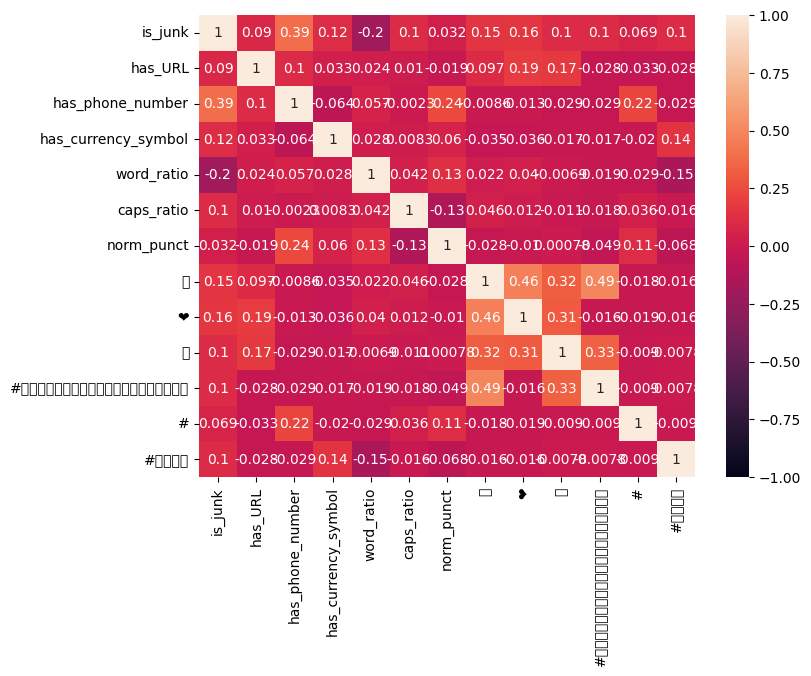

In [17]:
corr_df = chanel_all_features.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, vmin=-1, vmax=1)
plt.show()

<Axes: xlabel='is_junk', ylabel='count'>

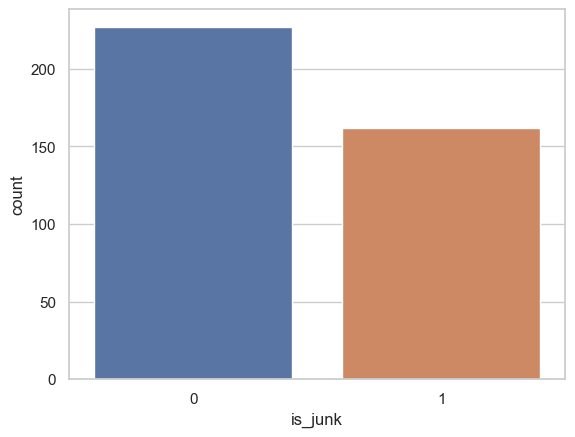

In [43]:
sns.countplot(x=chanel_all_features["is_junk"])

Boxplot word ratio 

<Axes: xlabel='is_junk', ylabel='word_ratio'>

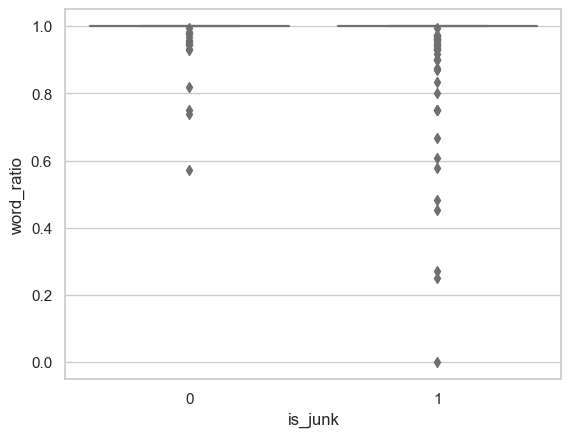

In [44]:
sns.boxplot(data  = chanel_all_features, 
            x     = "is_junk", 
            y     = "word_ratio",
            color = "skyblue")

Boxplot caps ratio

<Axes: xlabel='is_junk', ylabel='caps_ratio'>

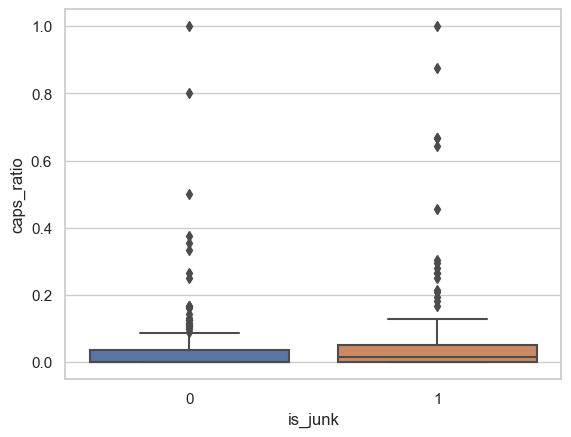

In [47]:
sns.boxplot(data  = chanel_all_features,
            x     = "is_junk",
            y     = "caps_ratio")

Boxplot nb ponctuation

<Axes: xlabel='is_junk', ylabel='norm_punct'>

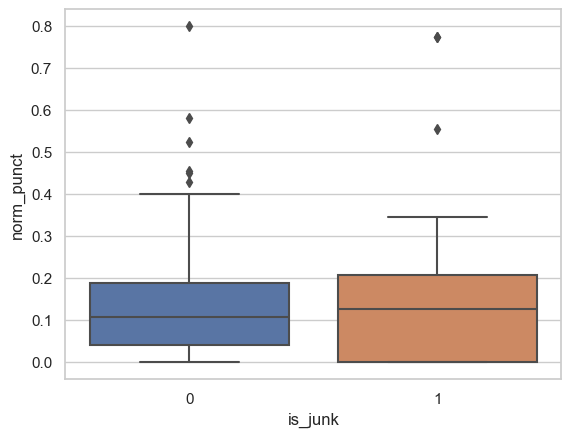

In [46]:
sns.boxplot(data = chanel_all_features,
            x    = "is_junk",
            y    = "norm_punct" )

graph numéro de téléphone, URL, et symbole monétaire


[Text(0.5, 0, 'Has a phone number in the text')]

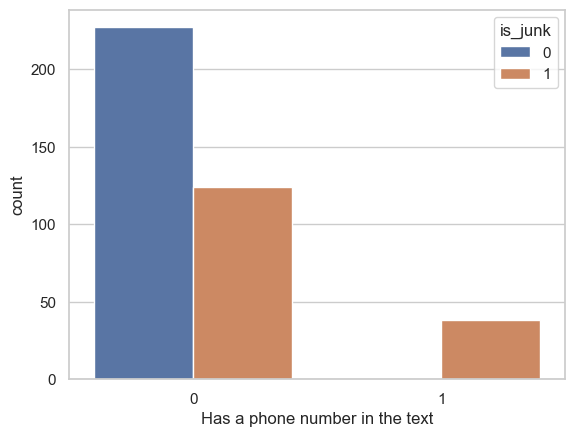

In [49]:
ax1 = sns.countplot(data=chanel_all_features, x='has_phone_number', hue= 'is_junk')
ax1.set(xlabel = "Has a phone number in the text")


[Text(0.5, 0, 'Has a URL in the text')]

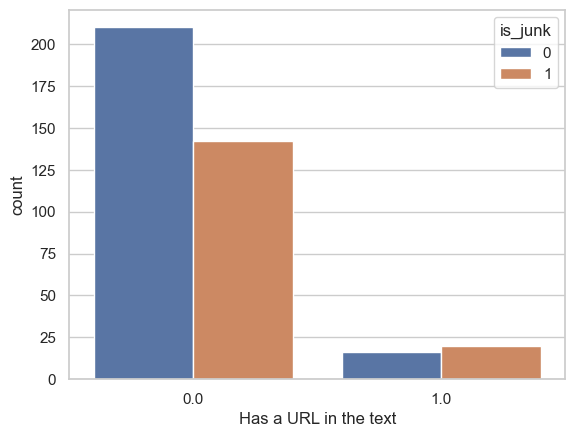

In [48]:
ax2 = sns.countplot(data=chanel_all_features, x='has_URL', hue= 'is_junk')
ax2.set(xlabel = "Has a URL in the text")

[Text(0.5, 0, 'Has a currency symbol in the text')]

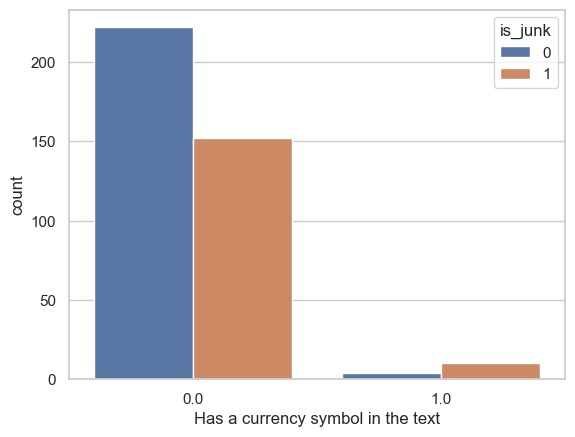

In [50]:
ax3 = sns.countplot(data=chanel_all_features, x='has_currency_symbol', hue= 'is_junk')
ax3.set(xlabel = "Has a currency symbol in the text")

# Arbre de decision

In [43]:
train,test = utilities.train_test(data = chanel_all_features.dropna().drop('text',axis=1), y = 'is_junk', f_y0= 0.7, f_y1= 0.7)

In [44]:
X_train = train.drop('is_junk',axis=1)
y_train = train['is_junk']
X_test = test.drop('is_junk',axis=1)
y_test = test['is_junk']

Arbre

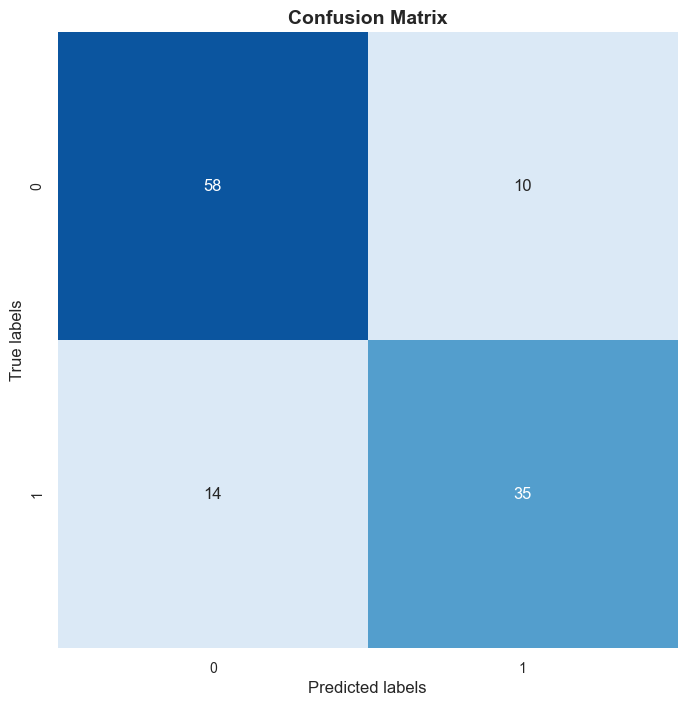

AUC : 0.7836134453781514
Accuracy score : 0.7948717948717948


In [48]:
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth=8, ccp_alpha = 0.011, min_samples_leaf = 5)
tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

In [46]:
from sklearn.model_selection import cross_val_score
cross_val_score(tree5, chanel_all_features.dropna().drop(['text','is_junk'],axis=1), chanel_all_features.dropna()['is_junk'], cv=10)

array([0.76923077, 0.82051282, 0.69230769, 0.79487179, 0.69230769,
       0.69230769, 0.79487179, 0.76923077, 0.73684211, 0.68421053])